# CUNY DATA608 
## HW Assignment 2
## Zachary Herold

In [1]:
import os
os.chdir('C:\\Users\\zhero\\Documents\\GitHub\\CUNY_DATA_608\\module2')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Importing the necessary packages
import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy
from sklearn import linear_model
from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
from shapely.geometry import Point, Polygon, shape
from functools import partial
from IPython.display import GeoJSON
from IPython.display import Image 

py.init_notebook_mode()

In [113]:
#Unused color schemes
#color_list = plt.cm.Set1(np.linspace(0, 1, 6))
#color = ['red','blue','green','black','yellow','cyan']
#color_key = {'A1':'#e8e8e8', 'B1':'#b0d5df', 'C1':'#64acbe', 'A2':'#e4acac',  'B2':'#ad9ea5', 'C2':'#627f8c', 'A3':'#c85a5a',  'B3':'#985356', 'C3':'#574249'}
#color_key = {'A1':'#e8e8e8', 'B1':'#dfb0d6', 'C1':'#be64ac', 'A2':'#ace4e4',  'B2':'#a5add3', 'C2':'#8c62aa', 'A3':'#5ac8c8',  'B3':'#5698b9', 'C3':'#3b4994'}
#color_key = {'A1':'#e8e8e8', 'B1':'#cbb8d7', 'C1':'#9972af', 'A2':'#e4d9ac',  'B2':'#c8ada0', 'C2':'#976b82', 'A3':'#c8b35a',  'B3':'#af8e53', 'C3':'#804d36'}
#color_key = {'A1':'#e8e8e8', 'B1':'#cbb8d7', 'C1':'#1974D2', 'A2':'#e4d9ac',  'B2':'#c8ada0', 'C2':'#976b82', 'A3':'#c8b35a',  'B3':'#af8e53', 'C3':'#804d36'}


For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.


In [4]:
#First, noting all the features of the PLUTO dataset on the data subset
bk = pd.read_csv(r'PLUTO17v1.1/BK2017V11.csv')
bk.columns.values

array(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCenterDistrict', 'HealthArea', 'SanitBoro', 'SanitDistrict',
       'SanitSub', 'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3',
       'ZoneDist4', 'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2',
       'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass', 'LandUse',
       'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode',
       'LotType', 'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR',
       'BoroCode', 'BBL', 'CondoNo

In [5]:
# Code to read in v17, including only columns to use, to preempt MemoryErrors
column_names = ['YearBuilt', 'NumFloors', 'XCoord', 'YCoord', 'BBL', 'NumFloors', 'AssessLand', 'AssessTot']
bk = pd.read_csv(r'PLUTO17v1.1/BK2017V11.csv', usecols=column_names)
bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv', usecols=column_names)
mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv', usecols=column_names)
qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv', usecols=column_names)
si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv', usecols=column_names)
#Concatenating the entire 5 burroughs
ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

In [6]:
ny.tail()

NumFloors  AssessLand  AssessTot  YearBuilt         BBL    XCoord  \
859218        2.5       12419      28962       1925  5080500083  914679.0   
859219        2.5       12966      18987       1915  5080500086  914655.0   
859220        2.0       20016      29020       1915  5080500089  914679.0   
859221        2.0       12768      28224       1950  5080500092  914771.0   
859222        2.0       11016      28305       1945  5080500094  914822.0   

          YCoord  
859218  124874.0  
859219  124805.0  
859220  124758.0  
859221  124743.0  
859222  124709.0

In [7]:
# Getting rid of some outliers, with buildings of non-zeroes floors from 1851 to 2016
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2017) & (ny['NumFloors'] != 0)]
#Removing properties with no assessed value
ny = ny[ny['AssessLand'] != 0]

In [9]:
#Transforming the longitude and latitude coordinates
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

In [11]:
ny.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811764 entries, 1 to 859222
Data columns (total 9 columns):
NumFloors     811764 non-null float64
AssessLand    811764 non-null int64
AssessTot     811764 non-null int64
YearBuilt     811764 non-null int64
BBL           811764 non-null int64
XCoord        811764 non-null float64
YCoord        811764 non-null float64
lon           811764 non-null float64
lat           811764 non-null float64
dtypes: float64(5), int64(4)
memory usage: 61.9 MB


In [10]:
ny.describe()

NumFloors    AssessLand     AssessTot      YearBuilt           BBL  \
count  811764.000000  8.117640e+05  8.117640e+05  811764.000000  8.117640e+05   
mean        2.441129  9.448240e+04  4.349661e+05    1940.849145  3.514717e+09   
std         1.920443  3.834021e+06  1.032441e+07      29.019400  1.022349e+09   
min         0.500000  2.500000e+01  1.370000e+02    1851.000000  1.000020e+09   
25%         2.000000  7.440000e+03  2.328800e+04    1920.000000  3.032810e+09   
50%         2.000000  1.019200e+04  3.037000e+04    1931.000000  4.008560e+09   
75%         2.500000  1.493000e+04  4.561900e+04    1960.000000  4.104780e+09   
max       119.000000  3.211276e+09  6.877263e+09    2016.000000  5.080500e+09   

              XCoord         YCoord            lon            lat  
count  811764.000000  811764.000000  811764.000000  811764.000000  
mean   306736.960132   58353.659305     -76.429187      40.301046  
std      9887.380022    9285.771444       0.034900       0.025922  
min    278319.890400   36669.878400     -76.528903      40.239419  
25%    301625.508000   51257.911200     -76.447218      40.280925  
50%    307527.655200   57667.550400     -76.426671      40.299473  
75%    313770.340200   64264.641600     -76.404575      40.317665  
max    325306.639200   82989.420000     -76.363162      40.368738

# Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and 2D histograms (also check out their close relatives: 2D density plots and the more general form: heatmaps.

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [12]:
trace = go.Scatter(
    # Choosing BBL with knowledge it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig)

Scanning through the data we notice spikes in years that end with the digits 0 and 5. This may be due to inexact or only periodic recordkeeping pre-1980. 

## Question 1 

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [13]:
#binning buildings by number of floors, in increments of 10-floors, labels by integers
bins = list(range(0,130,10))
ny['TowerHeight_binned'] = pd.cut(ny['NumFloors'], bins, labels = (
        ['Fl_1-10', 'Fl_11-20', 'Fl_21-30', 'Fl_31-40', 'Fl_41-50', 'Fl_51-60', 
         'Fl_61-70', 'Fl_71-80', 'Fl_81-90', 'Fl_91-100', 'Fl_101-110', 'Fl_111-120']))
                    
#list(range(1,13)))

In [14]:
ny['TowerHeight_binned']

1          Fl_1-10
17         Fl_1-10
20         Fl_1-10
22         Fl_1-10
23        Fl_11-20
            ...   
859218     Fl_1-10
859219     Fl_1-10
859220     Fl_1-10
859221     Fl_1-10
859222     Fl_1-10
Name: TowerHeight_binned, Length: 811764, dtype: category
Categories (12, object): [Fl_1-10 < Fl_11-20 < Fl_21-30 < Fl_31-40 ... Fl_81-90 < Fl_91-100 < Fl_101-110 < Fl_111-120]

In [15]:
#constructing a cross-tabulated table 
xtab = pd.crosstab(index = ny['YearBuilt'], columns = ny['TowerHeight_binned'])
xtab.tail()

TowerHeight_binned  Fl_1-10  Fl_11-20  Fl_21-30  Fl_31-40  Fl_41-50  Fl_51-60  \
YearBuilt                                                                       
2012                   1363        36        16         2         4         2   
2013                   1230        34        11        11         7         1   
2014                   1442        45        15         2         3         3   
2015                   1441        52        22        10         6         3   
2016                   1098        43        17        12         5         2   

TowerHeight_binned  Fl_61-70  Fl_71-80  Fl_81-90  Fl_101-110  Fl_111-120  
YearBuilt                                                                 
2012                       1         0         1           0           0  
2013                       0         0         3           0           0  
2014                       5         0         0           0           0  
2015                       5         8         1           0           0  
2016                       1         1         0           0           0

In [16]:
#Counting the number of buildings in the database according to binning by floor
totals = xtab.sum(axis=0)
print(totals)

TowerHeight_binned
Fl_1-10       806217
Fl_11-20        4018
Fl_21-30         815
Fl_31-40         409
Fl_41-50         188
Fl_51-60          71
Fl_61-70          22
Fl_71-80          13
Fl_81-90           7
Fl_101-110         2
Fl_111-120         2
dtype: int64


In [17]:
# Removing buildings with less 21 stories 
ny_sub = ny[ny['TowerHeight_binned'] != 'Fl_1-10']
ny_sub = ny_sub[ny_sub['TowerHeight_binned'] != 'Fl_11-20']

In [22]:
xtab2 = pd.crosstab(index = ny_sub['YearBuilt'], columns = ny_sub['TowerHeight_binned'])

In [23]:
#Combining columns of tall buildings (61-70 with 71-80, and everything over 80)
xtab2.columns = xtab2.columns.add_categories(['Fl_61-80'])
xtab2.columns = xtab2.columns.add_categories(['Fl_81-120'])
xtab2['Fl_61-80'] = xtab2['Fl_61-70'] + xtab2['Fl_71-80']
xtab2['Fl_81-120'] = xtab2['Fl_81-90'] + xtab2['Fl_101-110'] + xtab2['Fl_111-120'] 

In [24]:
#Dropping the columns that were just combined, leaving 6 categories
xtab3 = xtab2.drop(['Fl_61-70','Fl_71-80','Fl_81-90','Fl_101-110','Fl_111-120'],axis=1)
xtab3.tail()

TowerHeight_binned  Fl_21-30  Fl_31-40  Fl_41-50  Fl_51-60  Fl_61-80  \
YearBuilt                                                              
2012                      16         2         4         2         1   
2013                      11        11         7         1         0   
2014                      15         2         3         3         5   
2015                      22        10         6         3        13   
2016                      17        12         5         2         2   

TowerHeight_binned  Fl_81-120  
YearBuilt                      
2012                        1  
2013                        3  
2014                        0  
2015                        1  
2016                        0

<Figure size 432x288 with 0 Axes>

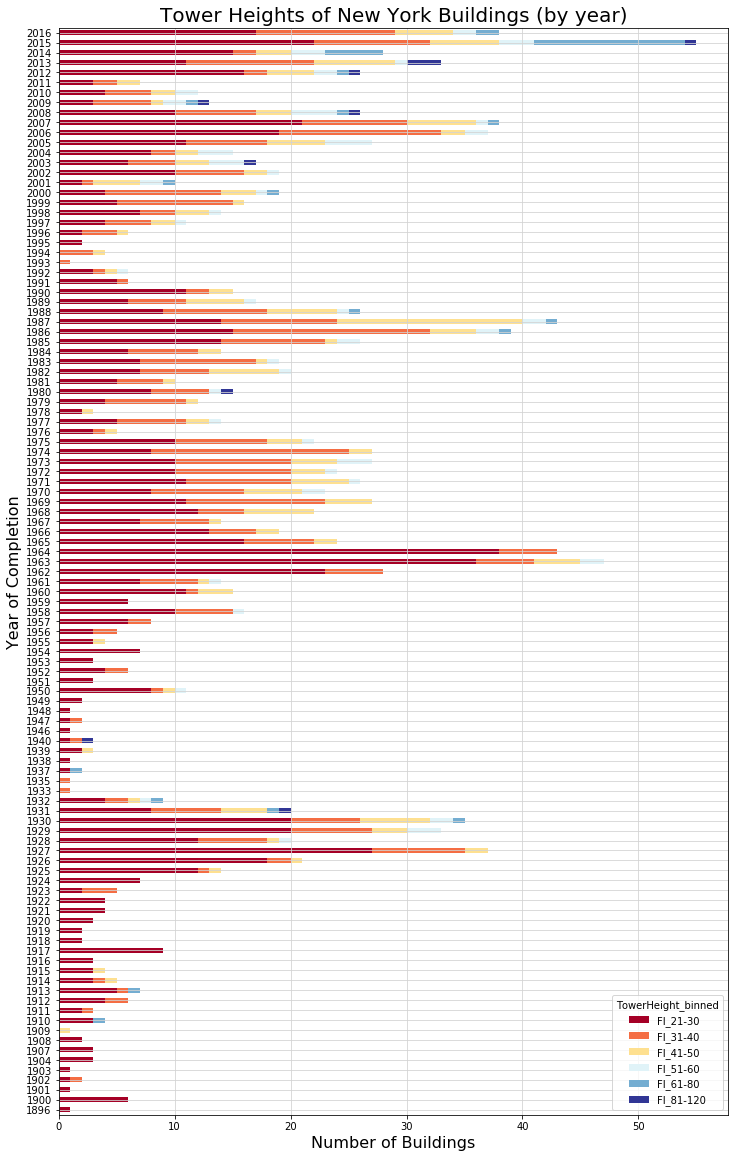

In [26]:
plt.figure()
color_list = plt.cm.RdYlBu(np.linspace(0, 1, 6))
xtab3.plot(kind="barh", figsize=(12,20), stacked=True, color = color_list)
plt.grid(b=True, which='major', color='#d3d3d3', linestyle='-')
plt.xlabel('Number of Buildings', fontsize = 16)
plt.ylabel('Year of Completion', fontsize = 16)
plt.title('Tower Heights of New York Buildings (by year)', fontsize = 20)
plt.show()

In [27]:
xtab4 = xtab3
for j in range(len(xtab4.columns)) :
    counter = 1
    for i in range(len(xtab4.index)) :
        if xtab4.iloc[i,j] != 0 :
            xtab4.iloc[i,j] = counter
            counter += 1
            
for j in range(len(xtab4.columns)) :
    for i in range(len(xtab4.index)) :
        if xtab4.iloc[i,j] > 8 or xtab4.iloc[i,j] == 0:
            xtab4.iloc[i,j] = float('nan')

<Figure size 432x288 with 0 Axes>

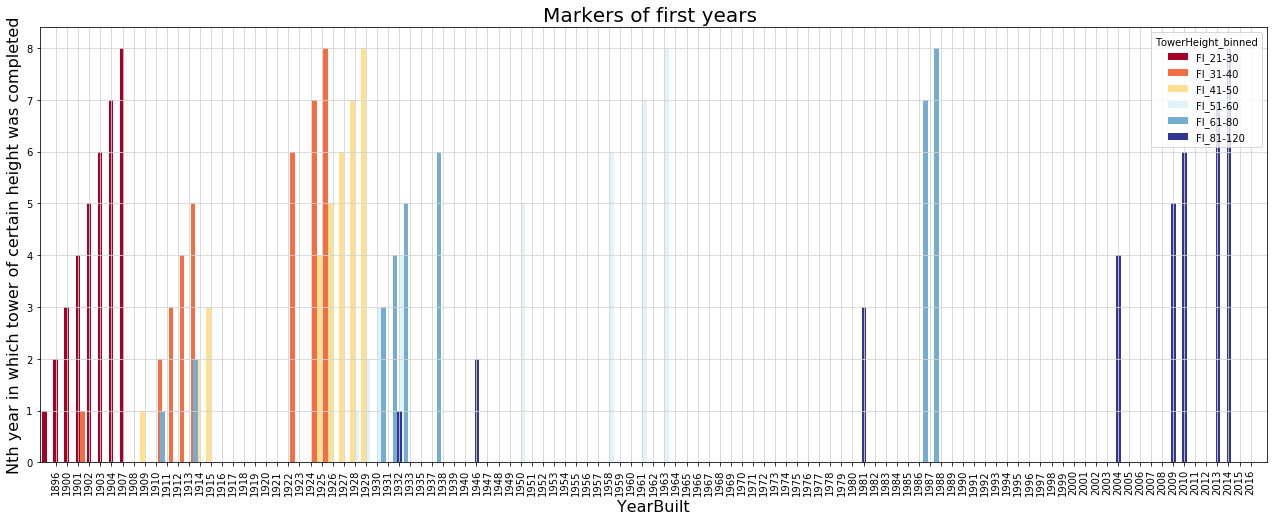

In [32]:
plt.figure()
xtab4.plot(kind="bar", figsize=(22,8), stacked=False, color = color_list, width = 2.5)
plt.grid(b=True, which='major', color='#d3d3d3', linestyle='-')
plt.xlabel('YearBuilt', fontsize = 16)
plt.ylabel('Nth year in which tower of certain height was completed', fontsize = 16)
plt.title('Markers of first years ', fontsize = 20)
plt.show()

In [60]:
danger_tower1 = ny_sub[ny_sub['YearBuilt'] == 1902]
danger_tower1 = danger_tower1[danger_tower1['TowerHeight_binned'] == 'Fl_31-40']
print(danger_tower1)

        NumFloors  AssessLand  AssessTot  YearBuilt         BBL       XCoord  \
376996       31.0    15867000  105990300       1902  1000157501  298661.0232   

            YCoord        lon        lat TowerHeight_binned  
376996  59846.2608 -76.458286  40.304528           Fl_31-40  


In [61]:
danger_tower2 = ny_sub[ny_sub['YearBuilt'] == 1909]
danger_tower2 = danger_tower2[danger_tower2['TowerHeight_binned'] == 'Fl_41-50']
print(danger_tower2)

        NumFloors  AssessLand  AssessTot  YearBuilt         BBL      XCoord  \
380652       42.0    10844550   16032354       1909  1010000001  301342.044   

           YCoord        lon        lat TowerHeight_binned  
380652  65801.748 -76.449275  40.321074           Fl_41-50  


The Singer BUilding, briefly the world's tallest tower, was later demolished in 1968, and remains the tallest building whose demolition was not an act of terrorism. It was destroyed, not out of safety concerns, but because its small interior dimensions were considered uneconomical.

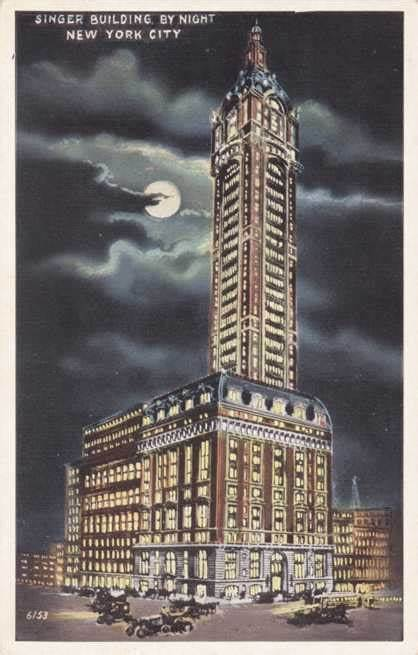

In [63]:
Image("img/th.jpg")

In [73]:
#Likely the Metropolitan Life Tower, although the floor count does not match its Wikipedia entry.
danger_tower3 = ny_sub[ny_sub['YearBuilt'] == 1910]
danger_tower3 = danger_tower3[danger_tower3['TowerHeight_binned'] == 'Fl_61-70']
print(danger_tower3)

        NumFloors  AssessLand  AssessTot  YearBuilt         BBL      XCoord  \
408307       65.0      936002    6932701       1910  1001897507  299385.228   

            YCoord        lon        lat TowerHeight_binned  
408307  61375.4424 -76.455844  40.308779           Fl_61-70  


In [78]:
#Table showing first occurrences of towers of certain binned heights.
xtab5 = xtab4.dropna(how='all').transpose()
xtab5.tail()

YearBuilt           1896  1900  1901  1902  1903  1904  1907  1908  1909  \
TowerHeight_binned                                                         
Fl_31-40             NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
Fl_41-50             NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   
Fl_51-60             NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
Fl_61-80             NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
Fl_81-120            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

YearBuilt           1910  ...  1961  1963  1980  1986  1987  2003  2008  2009  \
TowerHeight_binned        ...                                                   
Fl_31-40             NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
Fl_41-50             NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
Fl_51-60             NaN  ...   7.0   8.0   NaN   NaN   NaN   NaN   NaN   NaN   
Fl_61-80             1.0  ...   NaN   NaN   NaN   7.0   8.0   NaN   NaN   NaN   
Fl_81-120            NaN  ...   NaN   NaN   3.0   NaN   NaN   4.0   5.0   6.0   

YearBuilt           2012  2013  
TowerHeight_binned              
Fl_31-40             NaN   NaN  
Fl_41-50             NaN   NaN  
Fl_51-60             NaN   NaN  
Fl_61-80             NaN   NaN  
Fl_81-120            7.0   8.0  

[5 rows x 38 columns]

# Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.
As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [79]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Picnic', x = xlabels, y = ylabels)
]

py.iplot(data)

In [ ]:
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.
Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

In [ ]:
#Observing the minimum and maximum values of latitude and longitude, to use later in our city grid
ny[['lon','lat']].describe()

In [ ]:
NewYorkCity   = (( -76.53,  -76.36), (40.23, 40.37))
#NewYorkCity   = (( -77.22,  -77.16), (40.15, 40.20))
#NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.
Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their github repo. I would focus on the visualization pipeline and the US Census Example for the question below. Feel free to use my samples as templates as well when you work on this problem.
Question
You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.
Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

Question
You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.
Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

In [80]:
np.corrcoef(ny.AssessLand, ny.AssessTot)[0, 1]

0.8628228621451148

In [86]:
#Creating a variable of excess valuation, that is total tax assessment minus land assessment
ny_q2 = ny
ny_q2['AssessExcess'] = (ny_q2['AssessTot'] - ny_q2['AssessLand']).astype(float)

#Removing properties with no excess valuation, i.e. Land and Total Assessment are the same
ny_q2 = ny_q2[(ny_q2['AssessExcess'] != 0)]

In [87]:
#Taking Logs, bringing 'outliers' into the mix
ny_q2['AssessLand_log'] = np.log(ny_q2['AssessLand'])
ny_q2['AssessExcess_log'] = np.log(ny_q2['AssessExcess'])

In [88]:
print(ny_q2.sort_values(by=['AssessExcess_log'], ascending=True).head()) 

        NumFloors  AssessLand  AssessTot  YearBuilt         BBL       XCoord  \
806233        1.0        3903       3929       1930  5040850001  291537.2376   
828357        2.0       44894      44928       1959  5055200050  285819.1896   
122436        1.0        7429       7464       1935  3047820073  305784.1992   
649070        1.0        4188       4228       1931  4108670020  320407.2840   
649749        1.0        3761       3802       1928  4108920022  320170.4544   

            YCoord        lon        lat TowerHeight_binned  AssessExcess  \
806233  43932.9576 -76.482199  40.260314            Fl_1-10          26.0   
828357  42839.3352 -76.502566  40.256867            Fl_1-10          34.0   
122436  52442.3640 -76.432021  40.284759            Fl_1-10          35.0   
649070  60352.5336 -76.380400  40.307565            Fl_1-10          40.0   
649749  60050.1720 -76.381219  40.306718            Fl_1-10          41.0   

        AssessLand_log  AssessExcess_log  
806233       

# Valuation Framework

In the exercise, the author creates a categorical framework for evaluating the property values of NYC buildings, based on their tax assessments. On one axis, the properties are separated into three blocks according to their log-total tax assessment value at the 33 and 66 percentile marks. On the other axis, the properties are separated into three blocks according to the residual over/under predicted total assessment value given the explanatory variable of the land assessment value.  

The author classifies New York City Real Estate as follows: 
A - low percentile Total Tax Assessment (log) - low value - 0-33 percentile 
B - mid percentile Total Tax Assessment (log) - medium value - 34-66 percentile 
C - high percentile Total Tax Assessment (log) - high value  - 67-100 percentile

1 - low percentile Tax Assessment Residual over Predicted - undervalued - 0-33 percentile 
2 - mid percentile Tax Assessment Residual over Predicted - market-valued - 34-66 percentile 
3 - high percentile Tax Assessment Residual over Predicted - overvalued  - 67-100 percentile

Properties with negative residuals of predicted total tax assessment have been identified as ones with strong appreciation potential. In particular those in neighborhoods with high tax rate ('C1'), there is strong upside potential for investment.

In [90]:
#Setting first axis of bivariate map (AssessExcess_log)
p4 = max(ny_q2['AssessExcess_log'])
p3 = np.percentile(ny_q2['AssessExcess_log'], 66.6)
p2 = np.percentile(ny_q2['AssessExcess_log'], 33.3)
p1 = min(ny_q2['AssessExcess_log'])
print([p4,p3,p2,p1])

[22.022363397432226, 10.158865933983696, 9.676900579444158, 3.258096538021482]


In [89]:
# Create linear regression object
regr = linear_model.LinearRegression()
Y = ny_q2.AssessExcess_log.values
X = ny_q2.AssessLand_log.values
Y = Y.reshape(-1,1)
X = X.reshape(-1,1)
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [91]:
ny_q2['AssessExcess_pred'] = regr.predict(X)
ny_q2['AssessExcess_residual'] = ny_q2.AssessExcess_log - ny_q2['AssessExcess_pred']

In [92]:
#Setting second axis of bivariate map (AssessExcess_residual)
q4 = max(ny_q2['AssessExcess_residual'])
q3 = np.percentile(ny_q2['AssessExcess_residual'], 66.6)
q2 = np.percentile(ny_q2['AssessExcess_residual'], 33.3)
q1 = min(ny_q2['AssessExcess_residual'])
print([q4,q3,q2,q1])

[5.898078766670039, 0.1460473882091296, -0.33312946337482124, -8.24485749652828]


In the plot below we sketch out nine valuation quadrants, based on log total tax assessment and residual total valuation over predicted. 

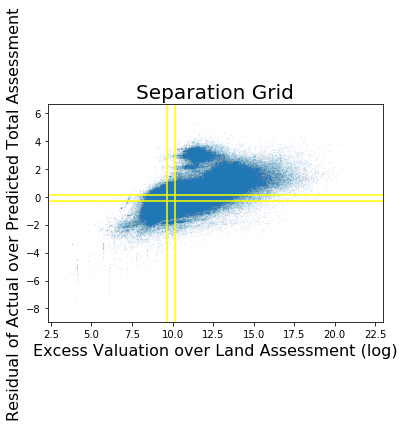

In [94]:
plt.scatter(ny_q2.AssessExcess_log, ny_q2.AssessExcess_residual, s=0.1, alpha=0.1 )
#plt.plot(X, regr.predict(X), color='black', linewidth=2)
plt.axvline(p3, color = 'yellow')
plt.axvline(p2, color = 'yellow')
plt.axhline(q3, color = 'yellow')
plt.axhline(q2, color = 'yellow')
plt.xlabel('Excess Valuation over Land Assessment (log)', fontsize = 14)
plt.ylabel('Residual of Actual over Predicted Total Assessment', fontsize = 12)
plt.title('Separation Grid', fontsize = 20)
plt.show()

In [96]:
#Creating the classifier
ny_q2['AssessExcess_rank'] = np.where(ny_q2['AssessExcess_log'] > p3, '3', 
                                 np.where(ny_q2['AssessExcess_log'] < p2, '1', '2'))
ny_q2['AssessResidual_rank'] = np.where(ny_q2['AssessExcess_residual'] > q3, 'C', 
                                 np.where(ny_q2['AssessExcess_residual'] < q2, 'A', 'B'))
ny_q2['TaxClassifier'] = ny_q2['AssessResidual_rank'] + ny_q2['AssessExcess_rank'] #Concatenation
ny_q2['TaxClassifier'] = pd.Categorical(ny_q2['TaxClassifier']) #Datatype conversion

We can see from the frequency table below that most properties are along the diagonal, with properties with non-downtown low tax value properties  typically being undervalued (negative residuals) ('A1'), medium value properties close to prediction ('B2') and high value downtown properties with positive residuals ('C3').  

Those undervalued properties in relative high tax value neighborhoods, yet with negative residuals, are identified as the properties that could see significant gains given investment. As such, we target the properties classified as 'C1' and 'B1'. 

In [100]:
ny_q2['TaxClassifier'].value_counts()

A1    177955
C3    175638
B2    134728
C2     74175
B1     71034
B3     64522
A2     61402
A3     30927
C1     21283
Name: TaxClassifier, dtype: int64

In [134]:
#Color scheme from https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/

color_key = {'A3':'#e8e8e8', 'A2':'#dfb0d6', 'A1':'#be64ac', 'B3':'#ace4e4',  'B2':'#a5add3', 'B1':'#de1738', 'C3':'#5ac8c8',  'C2':'#5698b9', 'C1':'#39FF14'}

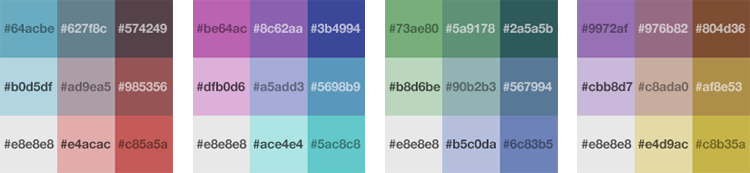

In [133]:
#Using the second bivariate color scheme, modifying bright neon green for 'C1' and bright red for 'B1' to highlight
Image("img/js_bivariatePalettes.png")

In [ ]:
Neon green and bright red clusters in the map below represent neighborhoods with appreciation potential. 

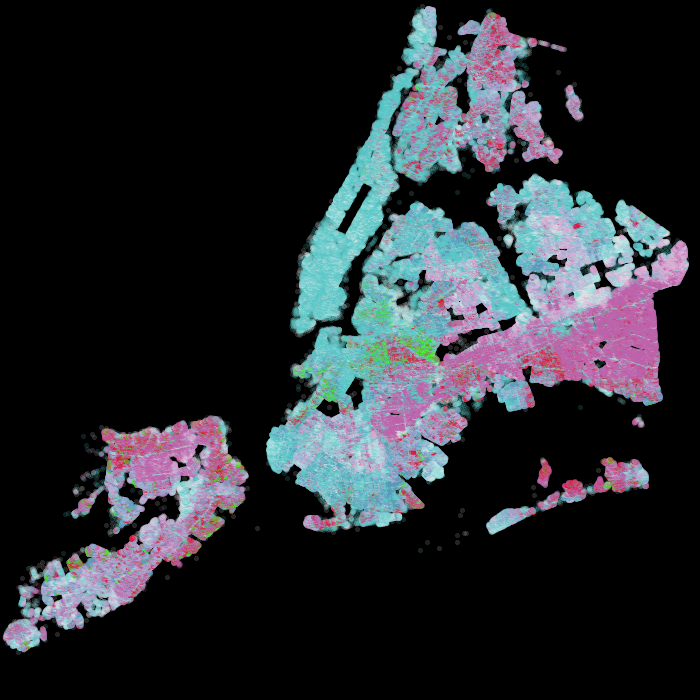

In [132]:
NewYorkCity   = (( -76.53,  -76.36), (40.23, 40.37))
#NewYorkCity   = (( -77.22,  -77.16), (40.15, 40.20))
#NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny_q2, 'lon', 'lat', ds.count_cat('TaxClassifier'))
view = tf.shade(agg, color_key=color_key, how='log')
export(tf.spread(view, px=2), 'firery')

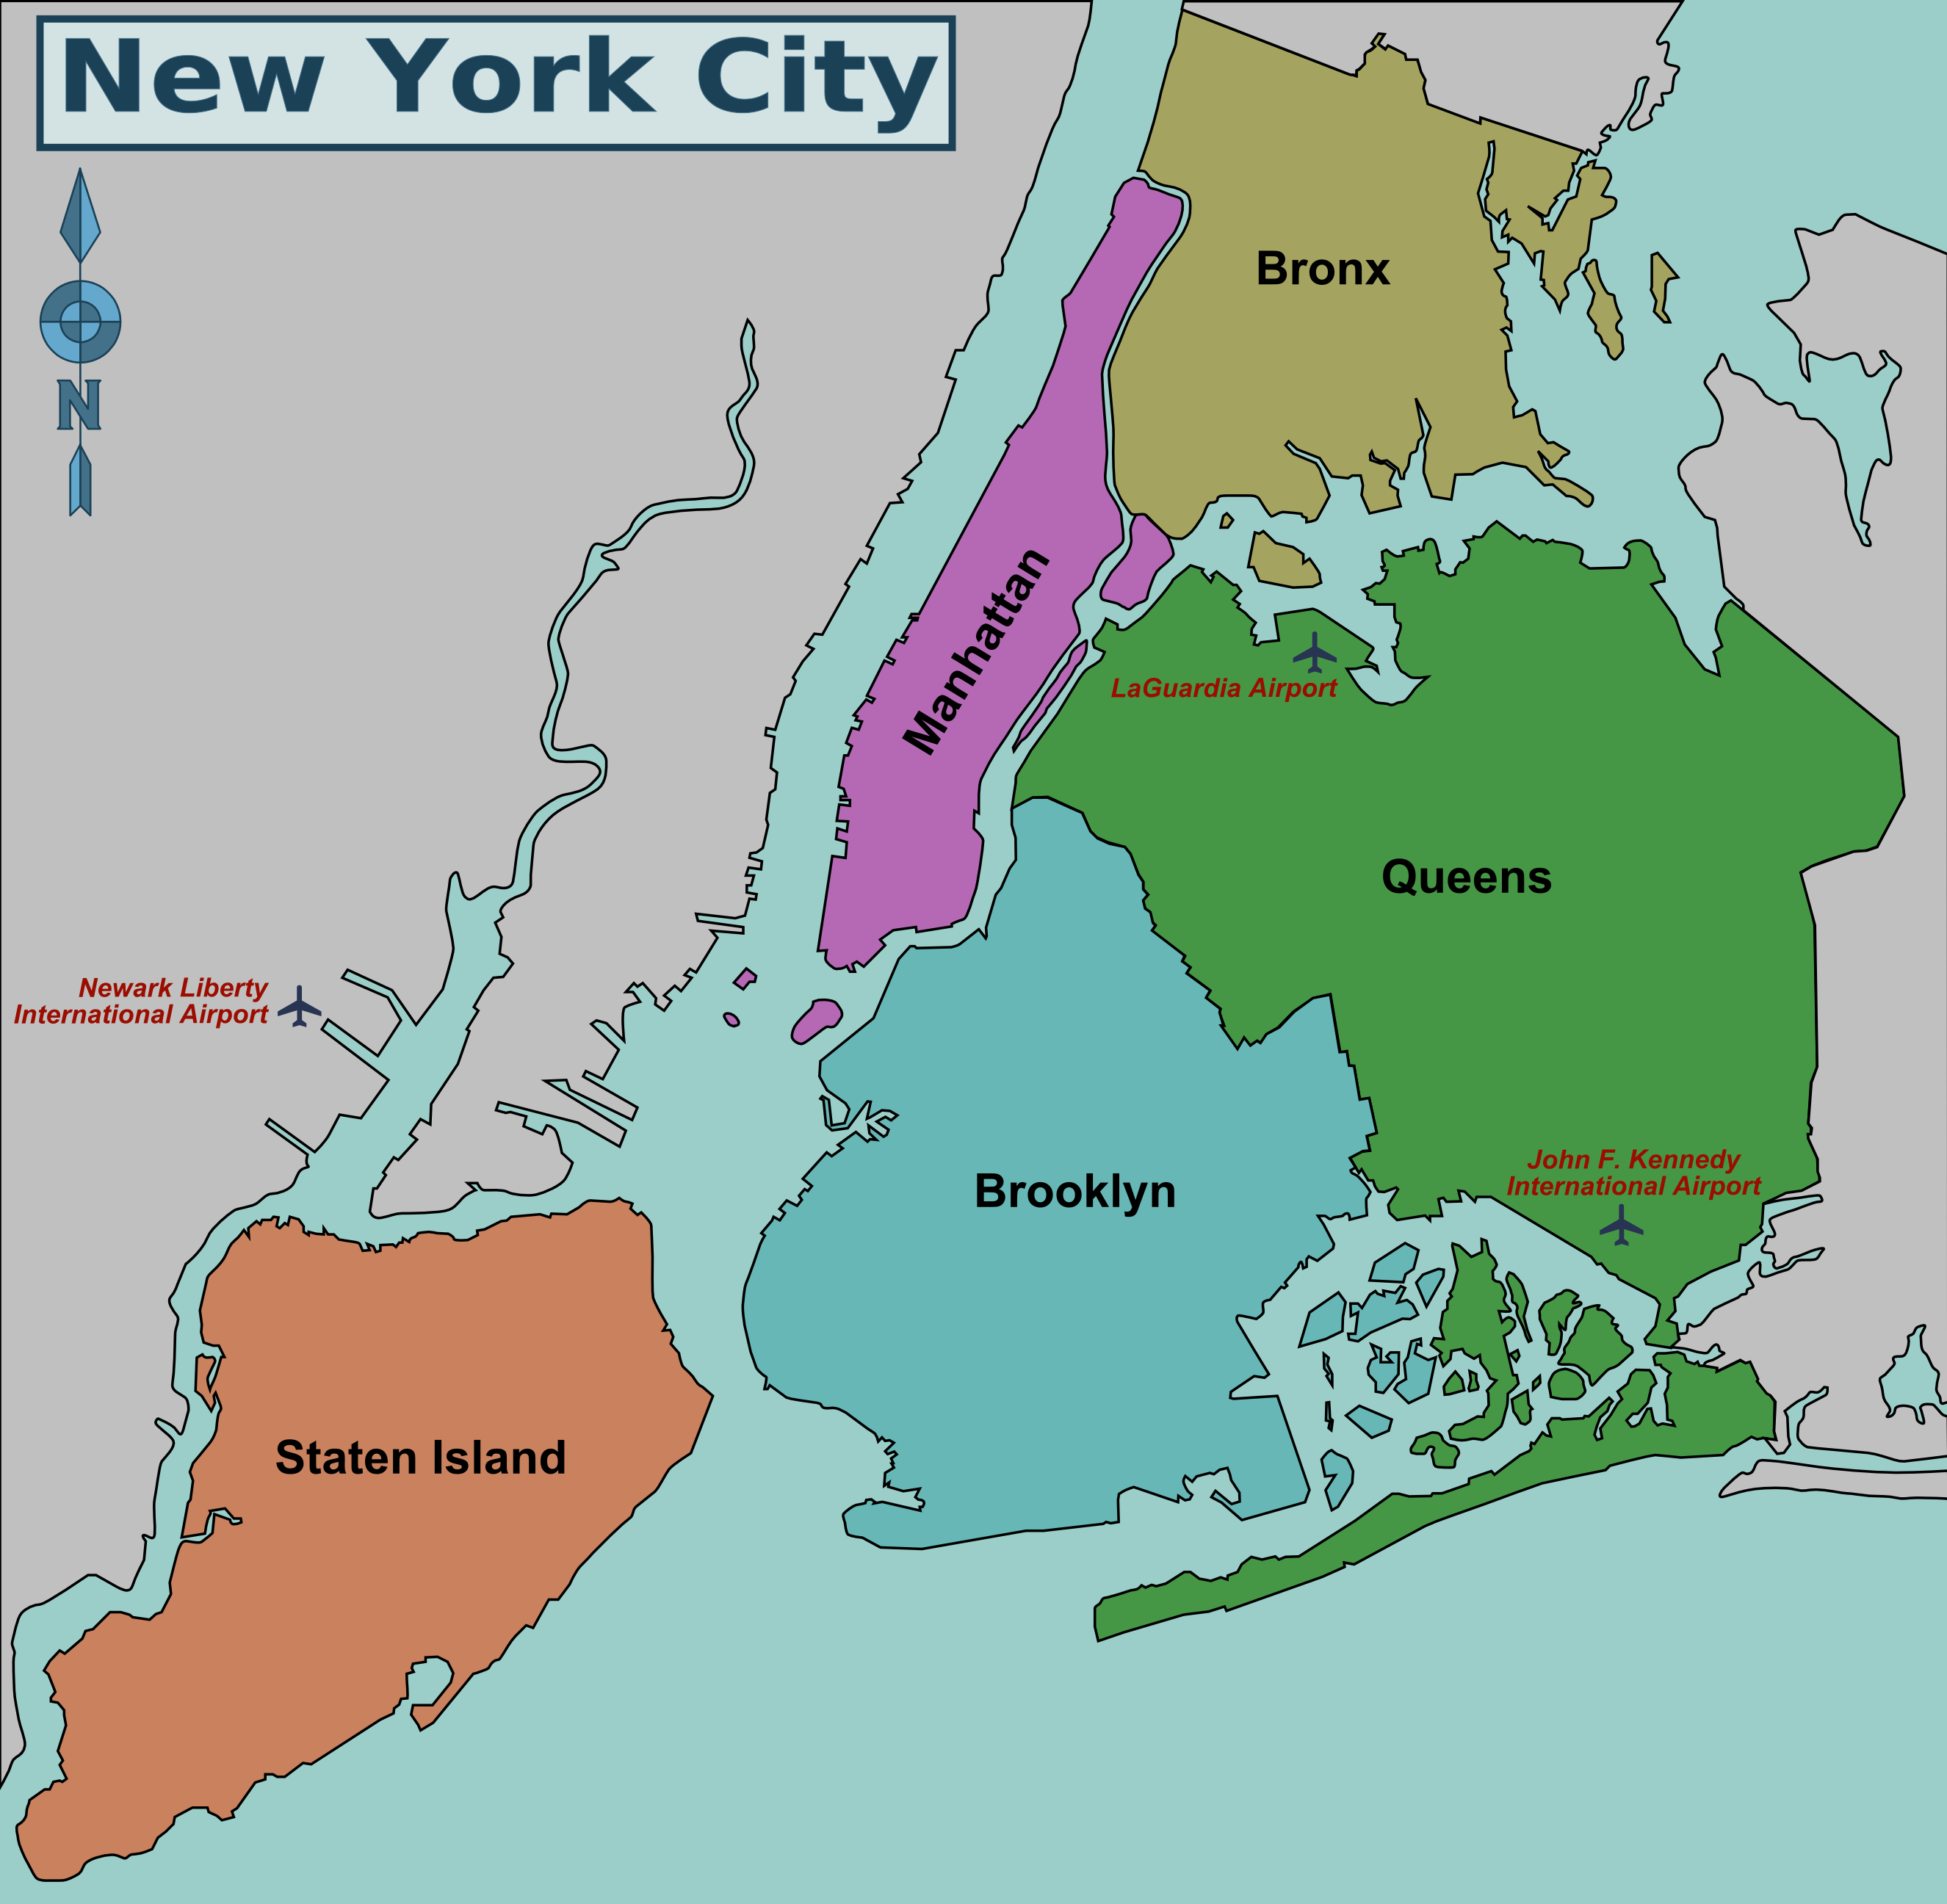

In [149]:
#Comparing to a map of the burroughs
Image("img/nyc-borough-map.png", width=600, height=600)

In [135]:
from datashader.utils import lnglat_to_meters as webm
x_range,y_range = [list(r) for r in webm(*NewYorkCity)]
plot_width  = int(900)
plot_height = int(plot_width*7.0/12)

# Conclusion 
The author's conclusion is that the highest concentration of undervalued properties with high tax base ('C1'), with high appreciation potential, is in northern Brooklyn. Other investment properties with medium tax rate ('B1') are well-dispursed through the city (except Manhattan) with apparent clustering in Queens (near Kennedy airport), northern Bronx, Eastern Staten Island, and Central Brooklyn. 

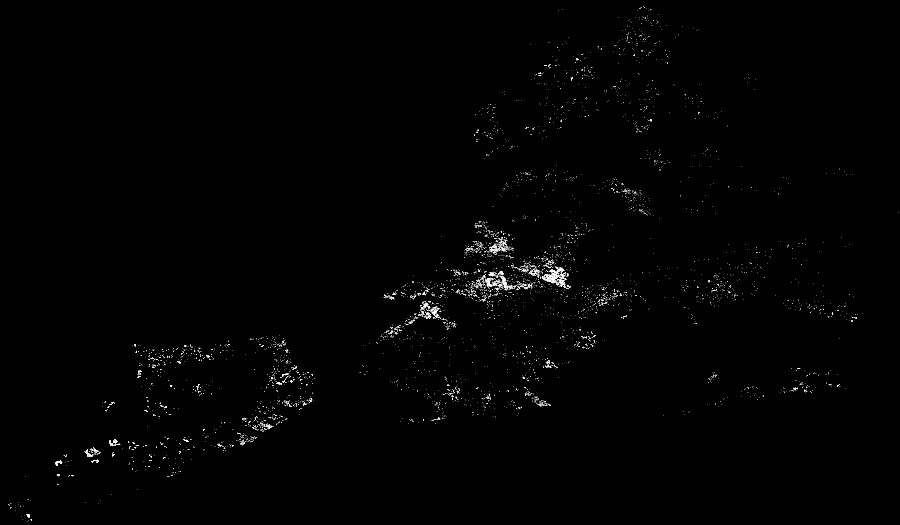

In [136]:
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height)
aggc = cvs.points(ny_q2, 'lon', 'lat', ds.count_cat('TaxClassifier'))
export(tf.shade(aggc.sel(TaxClassifier = 'C1'), cmap=cm(Greys9,0.25), how='eq_hist'),"Undervalued_Property - Opportunities")

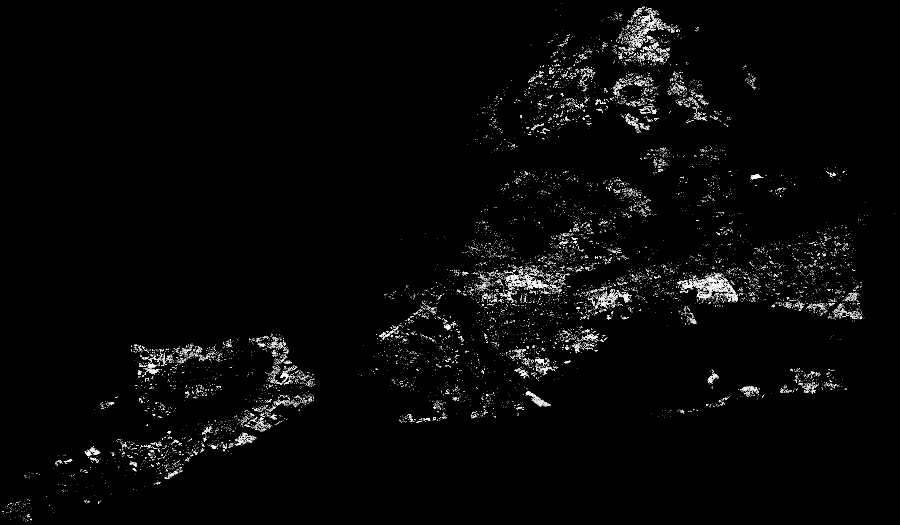

In [137]:
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height)
aggc = cvs.points(ny_q2, 'lon', 'lat', ds.count_cat('TaxClassifier'))

export(tf.shade(aggc.sel(TaxClassifier = 'B1'), cmap=cm(Greys9,0.25), how='eq_hist'),"LowVal_Real_Estate")